In [4]:
import numpy as np 
import pandas as pd 
import h5py
import glob
import pyodc
import os
import sys

from scipy.interpolate import interp1d

import matplotlib.pylab as plt

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua4 as eua


In [56]:
def international_height_formula_reverse(z: float) -> float:
    """
    Calculate the pressure (p) in hPa using the reverse of the International Height Formula (IHF).

    Parameters:
    z (float): Height in meters. Must be greater than or equal to 0.

    Returns:
    float: Pressure in hPa.

    Raises:
    ValueError: If the height value is less than 0.
    """
    
    # Constants
    T0 = 288.15  # Standard temperature at sea level in Kelvin
    L = 0.0065   # Temperature lapse rate in K/m
    P0 = 1013.25 # Standard pressure at sea level in hPa
    g0_R = 1 / 5.255

    # Reverse International Height Formula
    p = P0 * (1 - (z * L / T0)) ** (1 / g0_R)
    return p

# Example usage:
height = 2000  # Example height in meters
pressure = international_height_formula_reverse(height)
print(f"The calculated pressure for a height of {height} meters is {pressure:.2f} hPa.")

The calculated pressure for a height of 2000 meters is 794.98 hPa.


In [1]:
def calculate_pressure(p0, L, T0, z, R=287.053, g=9.80665):
    """
    Calculate the pressure (p) at a given height (z) using the polytropic height formula.
    
    Parameters:
    - p0: float, pressure at sea level (in Pascals)
    - L: float, temperature lapse rate (in K/m, usually -0.0065)
    - T0: float, reference temperature at sea level (in Kelvin)
    - z: float, height above sea level (in meters)
    - R: float, specific gas constant for dry air (default: 287.053 J/(kg·K))
    - g: float, acceleration due to gravity (default: 9.80665 m/s²)
    
    Returns:
    - float, pressure at height z
    """
    # Exponent in the formula
    exponent = g / (L * R)
    
    # Calculate pressure
    p = p0 * (1 - (L * z) / T0) ** exponent
    
    return p

# Example usage
p0 = 101325  # Pressure at sea level in Pascals
L = -0.0065  # Temperature lapse rate in K/m
T0 = 288.15  # Temperature at sea level in Kelvin
z = 2000     # Height in meters

pressure = calculate_pressure(p0, L, T0, z)
print(f"Pressure at {z} meters: {pressure:.2f} Pa")

Pressure at 2000 meters: 80351.08 Pa


In [70]:
bg_files = glob.glob('/mnt/users/scratch/leo/scratch/era5/odbs/1/*202301*11035')[0]

df_decoded = pyodc.read_odb(bg_files, single=True)
subset = df_decoded[['vertco_type@body', 'vertco_reference_1@body', 'andate', 'antime', 'obsvalue@body', 'varno@body', 'fg_depar@body', 'biascorr@body']]
temp_data = subset[subset['varno@body'] == 2]
z_data = subset[subset['varno@body'] == 1]
z_data = z_data[['vertco_reference_1@body', 'andate', 'antime', 'obsvalue@body']]
z_data.rename(columns={'obsvalue@body': 'gpm'}, inplace=True)
temp_data['temp_final'] = temp_data['obsvalue@body'] - temp_data['fg_depar@body'] - temp_data['biascorr@body']
era_df = temp_data.merge(z_data, on=['vertco_reference_1@body', 'andate', 'antime'])
era_df

/srvfs/home/uvoggenberger/.local/lib/python3.10/site-packages/pyodc/frame.py:405: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(
/tmp/ipykernel_2368686/523677354.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data['temp_final'] = temp_data['obsvalue@body'] - temp_data['fg_depar@body'] - temp_data['biascorr@body']


,vertco_type@body,vertco_reference_1@body,andate,antime,obsvalue@body,varno@body,fg_depar@body,biascorr@body,temp_final,gpm
0,1,100000.0,20230101,0,-3.402823e+38,2,-3.402823e+38,NaN,NaN,1882.876831
1,1,100000.0,20230101,0,-3.402823e+38,2,-3.402823e+38,NaN,NaN,1882.876831
2,1,99660.0,20230101,0,2.792300e+02,2,-8.078704e+00,0.0,287.308715,2147.656250
3,1,99660.0,20230101,0,2.792300e+02,2,-8.078704e+00,0.0,287.308715,2147.656250
4,1,99590.0,20230101,0,2.808100e+02,2,-6.460297e+00,0.0,287.270294,2206.496338
...,...,...,...,...,...,...,...,...,...,...
586183,1,10050.0,20230131,120000,2.112600e+02,2,-3.115249e+00,0.0,214.375243,155827.671875
586184,1,10040.0,20230131,120000,2.111900e+02,2,-3.187938e+00,0.0,214.377941,155935.546875
586185,1,10040.0,20230131,120000,2.111900e+02,2,-3.187938e+00,0.0,214.377941,155935.546875
586186,1,10000.0,20230131,120000,2.111100e+02,2,-3.278696e+00,0.0,214.388696,156151.281250


In [64]:
cfile = glob.glob('/mnt/users/scratch/leo/scratch/converted_v25/long/*11035*.nc')[0]
cdmfile = eua.CDMDataset(cfile)
df = cdmfile.to_dataframe(groups = ['observations_table'], variables= ['date_time', 'observation_value', 'observed_variable', 'z_coordinate'])
df = df[df.observed_variable == 117]

In [92]:
target_date = pd.to_datetime('2023-01-01 12:00:00')

# Calculate the differences and find the closest date
df_preselect = df[df.date_time.dt.date == pd.to_datetime('2023-01-01').date()]




Timestamp('2023-01-01 11:34:10')

In [88]:
df_preselect['date_time'].apply(lambda target_date: df_preselect.loc[(df_preselect['date_time'] - target_date).abs().idxmin()])

,date_time,observation_value,observed_variable,z_coordinate
82589649,2023-01-01 11:34:10,336534.8125,117,580.0
82589650,2023-01-01 11:34:10,336534.8125,117,580.0
82589651,2023-01-01 11:34:10,336534.8125,117,580.0
82589652,2023-01-01 11:34:10,336534.8125,117,580.0
82589653,2023-01-01 11:34:10,336534.8125,117,580.0
...,...,...,...,...
82595409,2023-01-01 23:30:30,343321.0000,117,500.0
82595410,2023-01-01 23:30:30,343321.0000,117,500.0
82595411,2023-01-01 23:30:30,343321.0000,117,500.0
82595412,2023-01-01 23:30:30,343321.0000,117,500.0


In [122]:
date = 20230101
pd.to_datetime(pd.to_datetime(date, format='%Y%m%d').strftime('%Y-%m-%d') + ' 12:00:00') 

Timestamp('2023-01-01 12:00:00')

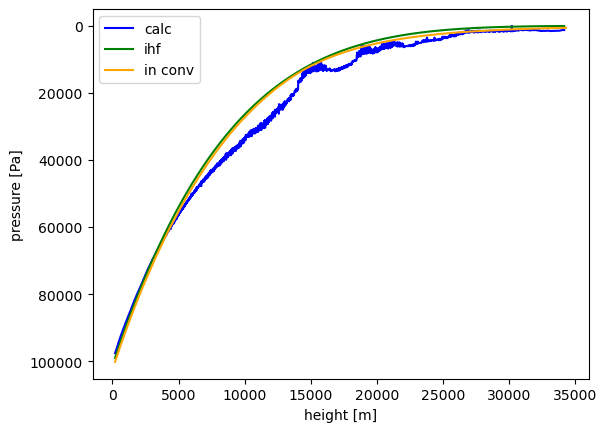

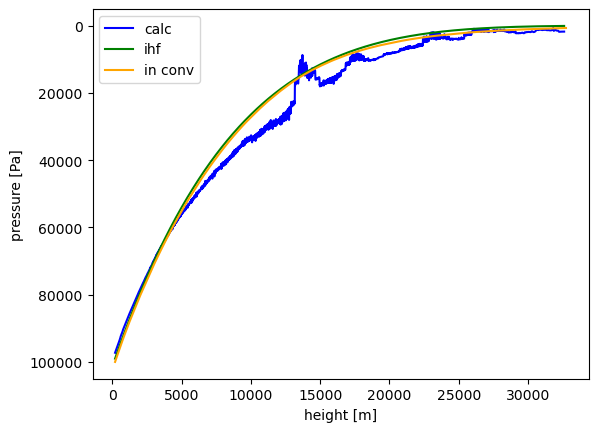

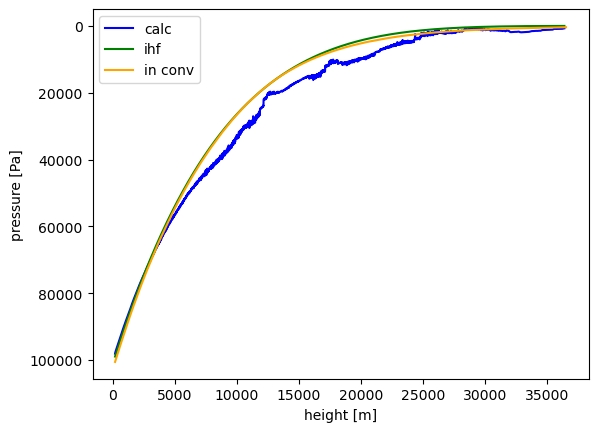

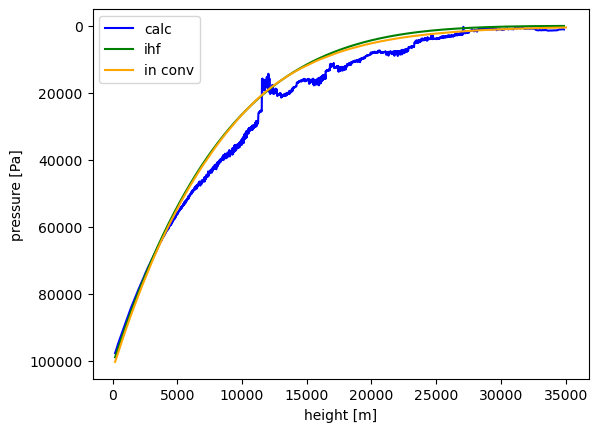

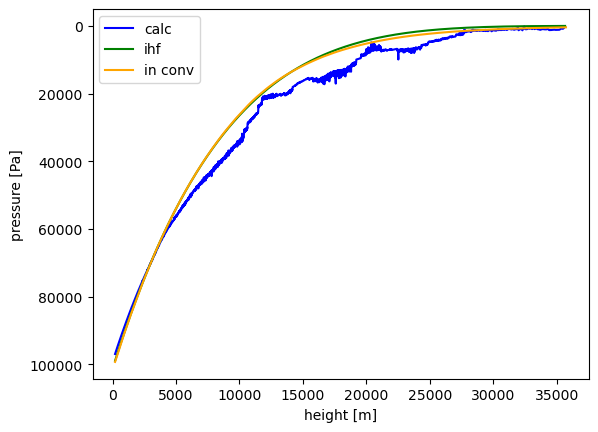

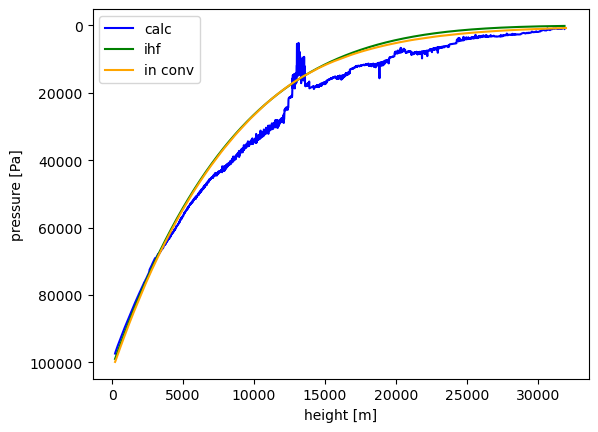

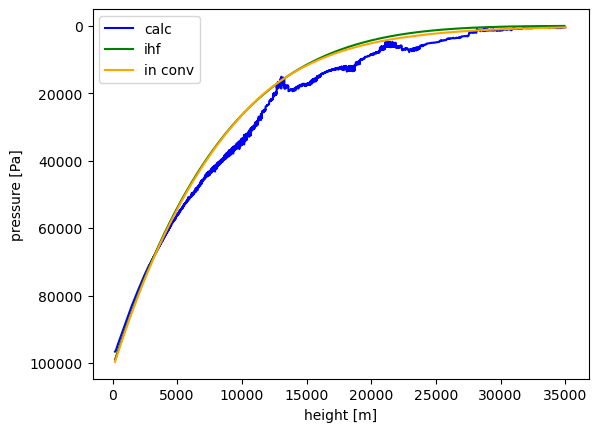

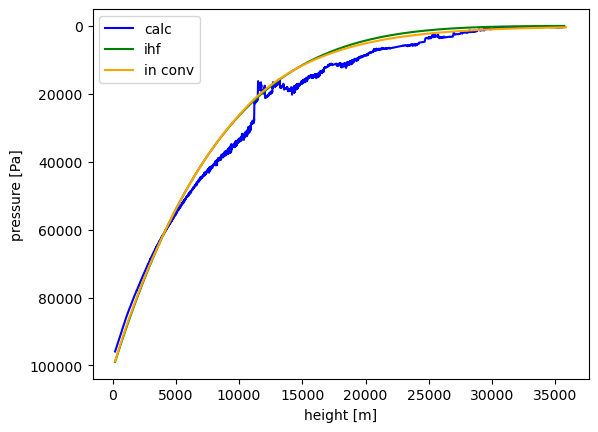

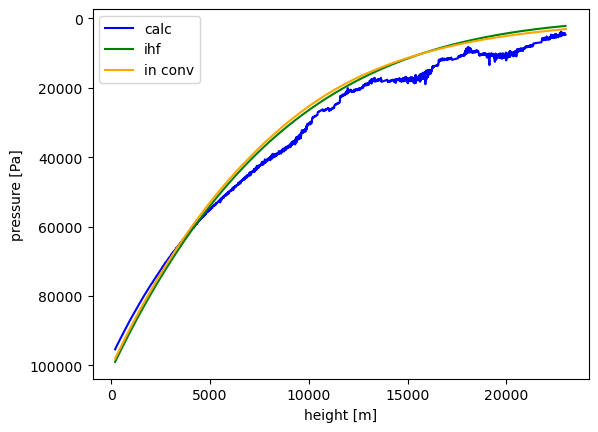

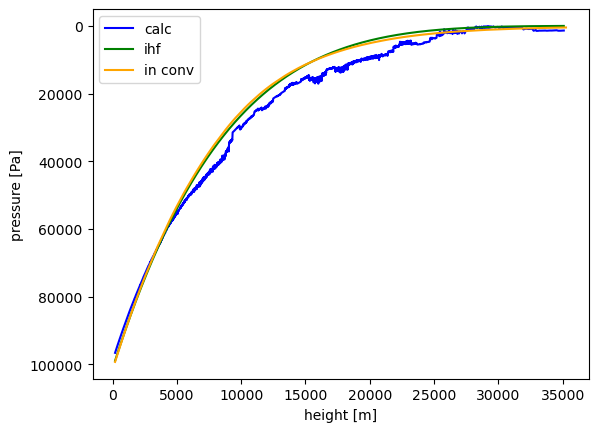

/tmp/ipykernel_2368686/888754537.py:20: RuntimeWarning: invalid value encountered in power
  p = p0 * (1 - (L * z) / T0) ** exponent


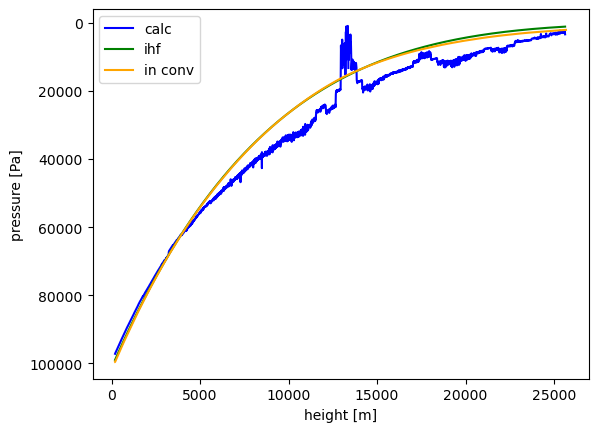

/tmp/ipykernel_2368686/888754537.py:20: RuntimeWarning: invalid value encountered in power
  p = p0 * (1 - (L * z) / T0) ** exponent


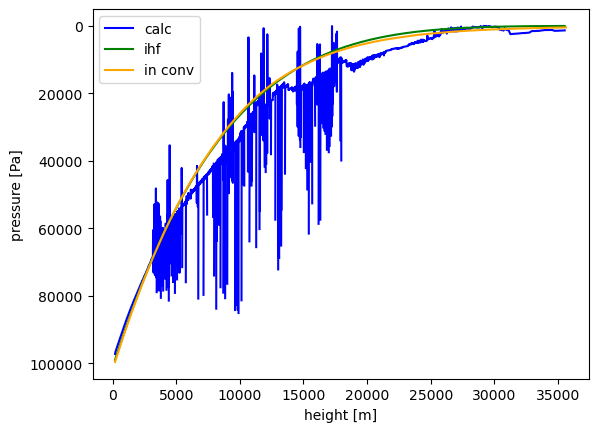

/tmp/ipykernel_2368686/888754537.py:20: RuntimeWarning: invalid value encountered in power
  p = p0 * (1 - (L * z) / T0) ** exponent


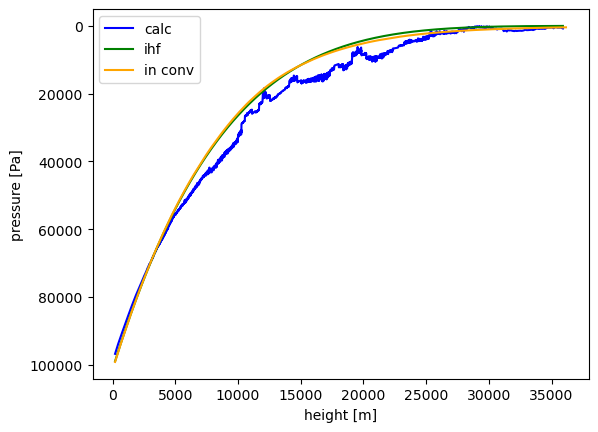

/tmp/ipykernel_2368686/888754537.py:20: RuntimeWarning: invalid value encountered in power
  p = p0 * (1 - (L * z) / T0) ** exponent


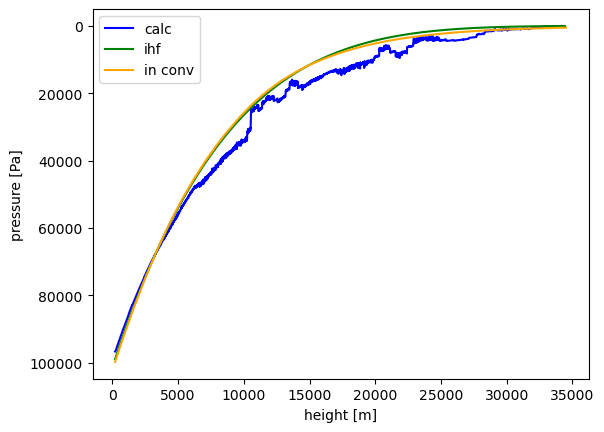

/tmp/ipykernel_2368686/888754537.py:20: RuntimeWarning: invalid value encountered in power
  p = p0 * (1 - (L * z) / T0) ** exponent


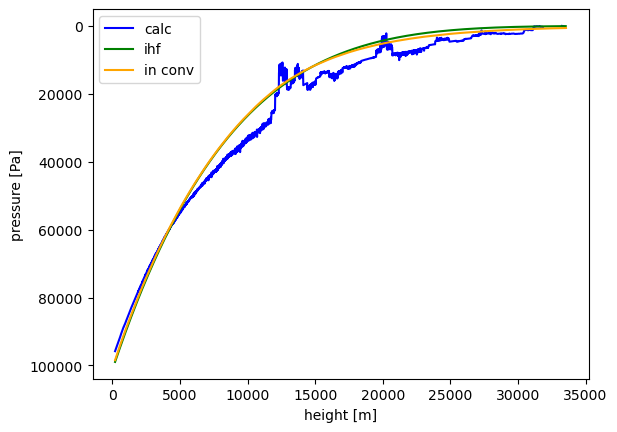

/tmp/ipykernel_2368686/888754537.py:20: RuntimeWarning: invalid value encountered in power
  p = p0 * (1 - (L * z) / T0) ** exponent


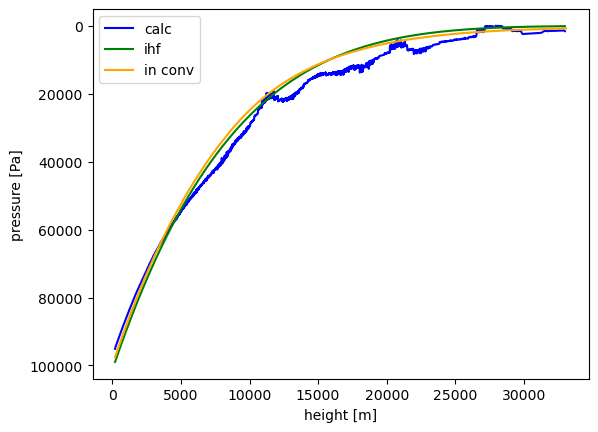

/tmp/ipykernel_2368686/2949690677.py:33: RuntimeWarning: invalid value encountered in scalar divide
  lapse.append(dt/dz)
/tmp/ipykernel_2368686/888754537.py:20: RuntimeWarning: invalid value encountered in power
  p = p0 * (1 - (L * z) / T0) ** exponent


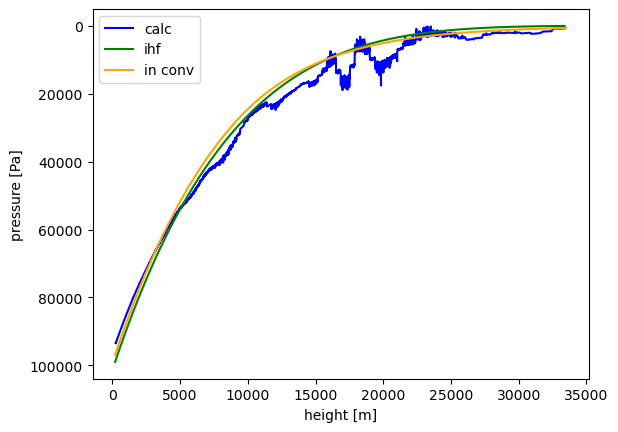

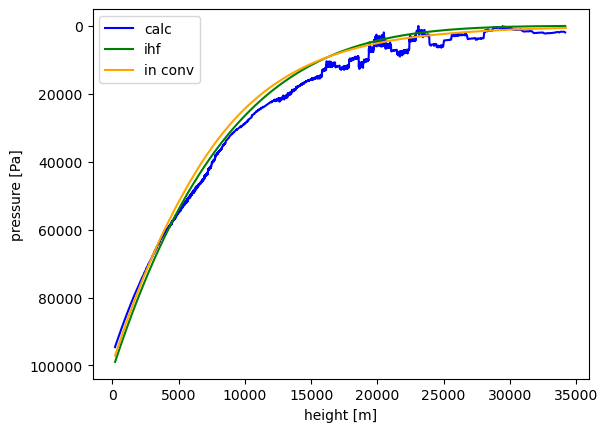

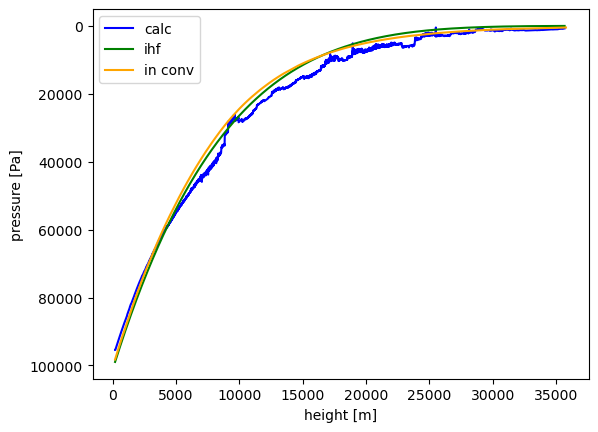

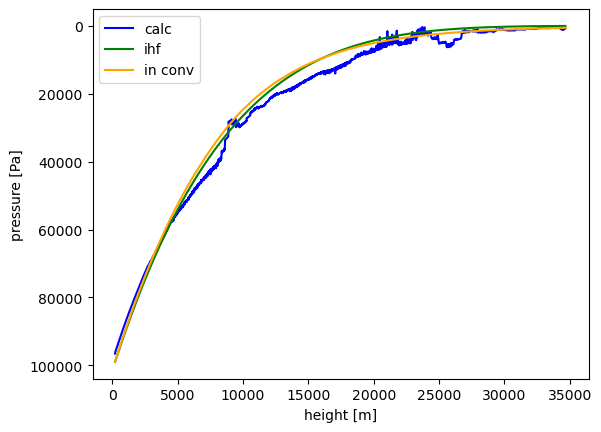

/tmp/ipykernel_2368686/2949690677.py:33: RuntimeWarning: invalid value encountered in scalar divide
  lapse.append(dt/dz)
/tmp/ipykernel_2368686/888754537.py:20: RuntimeWarning: invalid value encountered in power
  p = p0 * (1 - (L * z) / T0) ** exponent


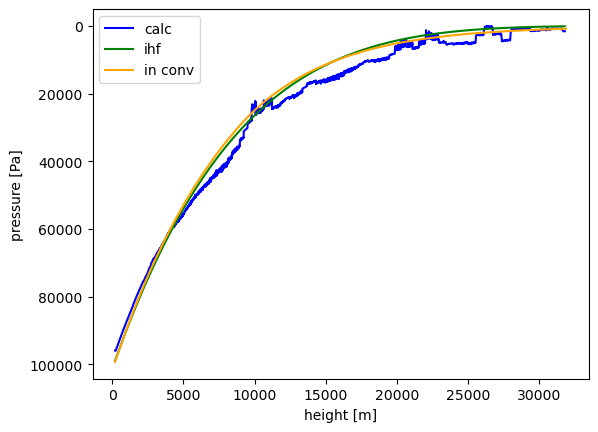

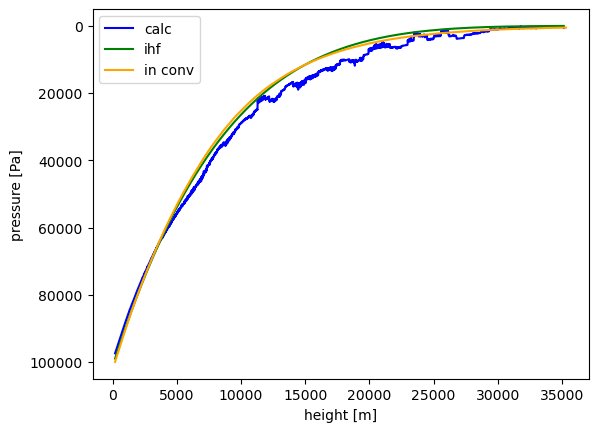

/tmp/ipykernel_2368686/888754537.py:20: RuntimeWarning: invalid value encountered in power
  p = p0 * (1 - (L * z) / T0) ** exponent


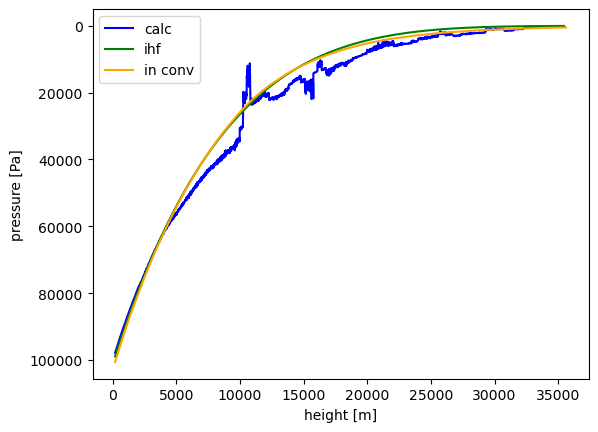

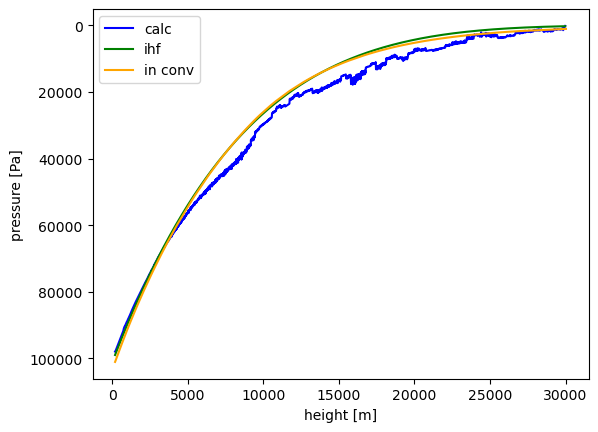

/tmp/ipykernel_2368686/888754537.py:20: RuntimeWarning: invalid value encountered in power
  p = p0 * (1 - (L * z) / T0) ** exponent


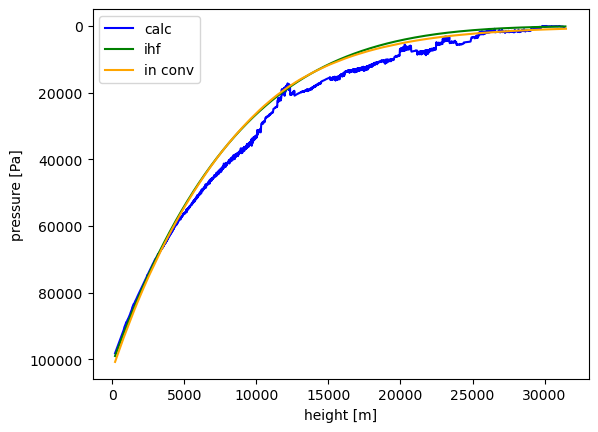

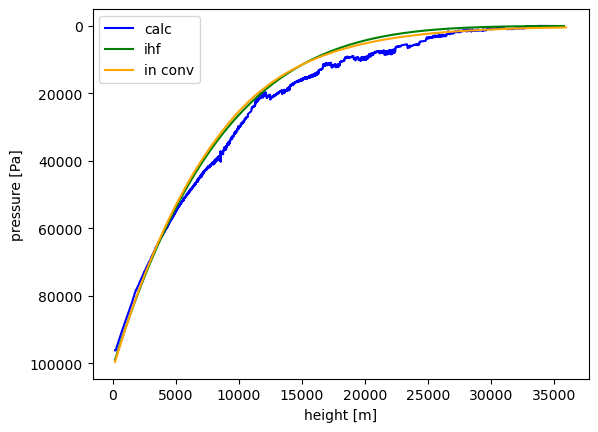

/tmp/ipykernel_2368686/888754537.py:20: RuntimeWarning: invalid value encountered in power
  p = p0 * (1 - (L * z) / T0) ** exponent


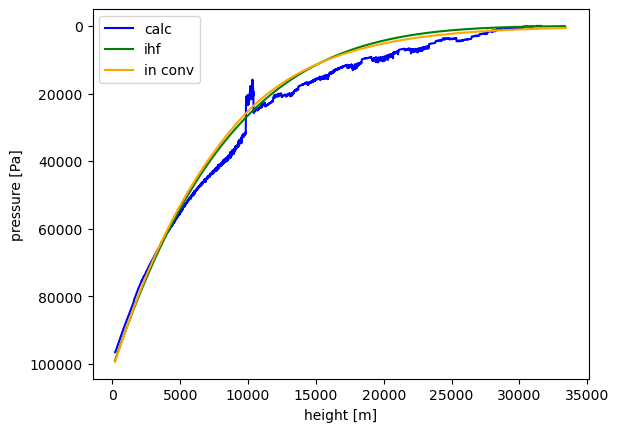

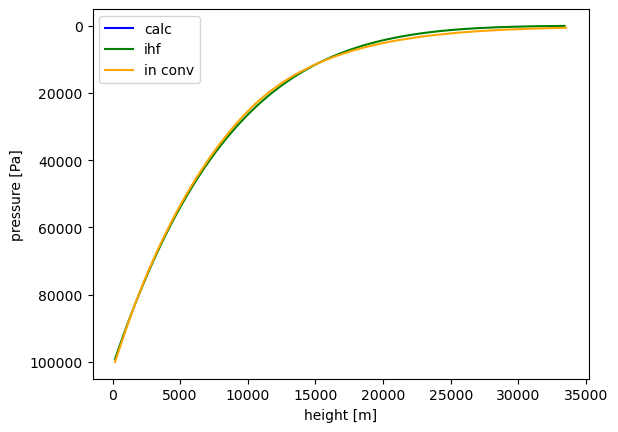

/tmp/ipykernel_2368686/888754537.py:20: RuntimeWarning: invalid value encountered in power
  p = p0 * (1 - (L * z) / T0) ** exponent


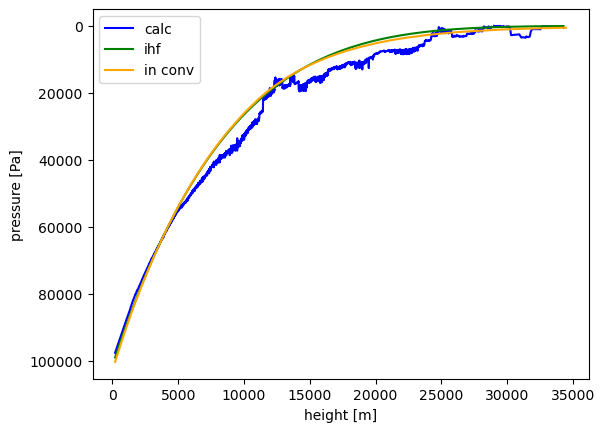

/tmp/ipykernel_2368686/2949690677.py:33: RuntimeWarning: invalid value encountered in scalar divide
  lapse.append(dt/dz)
/tmp/ipykernel_2368686/888754537.py:20: RuntimeWarning: invalid value encountered in power
  p = p0 * (1 - (L * z) / T0) ** exponent


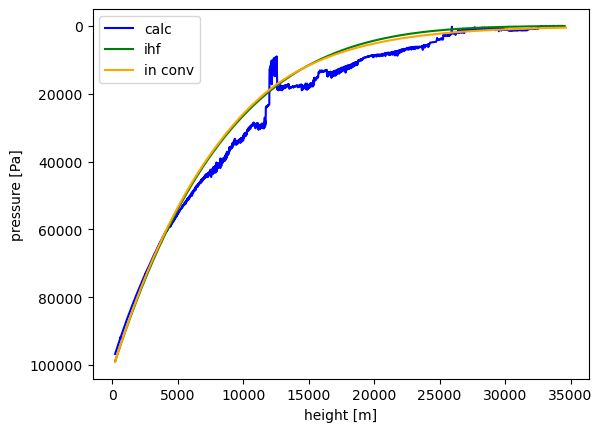

/tmp/ipykernel_2368686/2949690677.py:33: RuntimeWarning: invalid value encountered in scalar divide
  lapse.append(dt/dz)
/tmp/ipykernel_2368686/888754537.py:20: RuntimeWarning: invalid value encountered in power
  p = p0 * (1 - (L * z) / T0) ** exponent


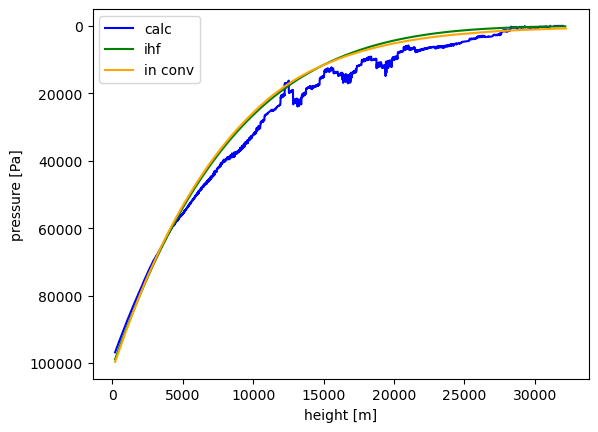

In [128]:
def find_closest_date(dates, target):
    return dates.loc[(dates - target).abs().idxmin()]

for date in range(20230101, 20230132):

    # Selecting the ascent:

    bg_df = era_df[(era_df.andate == date) & (era_df.antime == 120000)]

    target_date = pd.to_datetime(pd.to_datetime(date, format='%Y%m%d').strftime('%Y-%m-%d') + ' 12:00:00') 
    found_date = find_closest_date(df.date_time, target_date)



    # conv_df = df[df.date_time.dt.date == pd.to_datetime('2023-01-01').date()]
    conv_df = df[df.date_time == pd.to_datetime(found_date)]

    # Interpolating:

    bg_df = bg_df.sort_values(by = 'gpm')
    bg_df = bg_df.drop_duplicates(['gpm'])
    f_cubic = interp1d(bg_df['gpm'], bg_df['temp_final'], kind='cubic' , fill_value="extrapolate")

    inp_gpm = list(conv_df['observation_value'])
    inp_t = f_cubic(inp_gpm)

    # Calculating the lapse rate:

    lapse = []
    for i in range(1, len(inp_t)):
        dt = inp_t[i] - inp_t[i-1]
        dz = (inp_gpm[i] - inp_gpm[i-1]) / 9.80665
        lapse.append(dt/dz)

    # Calculating the pressure

    calc_p = calculate_pressure(bg_df['vertco_reference_1@body'].iloc[0], np.array(lapse),  bg_df['temp_final'].iloc[0], np.array(inp_gpm[1:])/ 9.80665)

    ihf_p = international_height_formula_reverse(np.array(inp_gpm[1:])/ 9.80665) * 100 # Pa -> hPa

    # Plotting

    plt.plot(np.array(inp_gpm[1:])/ 9.80665, calc_p, 'blue', label='calc')
    plt.plot(np.array(inp_gpm[1:])/ 9.80665, ihf_p, 'green', label='ihf')
    plt.plot(conv_df['observation_value']/ 9.80665 , conv_df['z_coordinate'], 'orange', label='in conv')
    plt.ylabel("pressure [Pa]")
    plt.xlabel("height [m]")

    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()
    plt.close()